# Portfolio 2: Analysing COVID-19 Data

For the second portfolio we'll look at the most relevant dataset to our lives at the moment: the global spread of COVID-19.   There is an open dataset avaialable that is updated often showing the number of cases in different regions of the world.  This is the source of the graphs and visualisations that you'll see on the news. 

Here are some sample stories for reference:

* [From the ABC](https://www.abc.net.au/news/2020-03-26/coronavirus-covid19-global-spread-data-explained/12089028)
* [From the Guardian](https://www.theguardian.com/australia-news/datablog/ng-interactive/2020/apr/06/coronavirus-cases-in-australia-map-curve-confirmed-numbers-stats-how-many-covid-19-nsw-by-postcode-maps-victoria-live-data-qld-sa-wa-tas-nt-act-latest-statistics)
* [Coronavirus in Australia](https://www.covid19data.com.au/)
* [ArcGIS Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) Johns Hopkins


In [27]:
import pandas as pd
import numpy as np

%matplotlib inline

## Getting the Data

The first step is to get a copy of the raw data.  The data is being made available by Johns Hopkins University in [this GitHub repository](https://github.com/CSSEGISandData/COVID-19). We're interestd in the global confirmed cases dataset but you can also get data on deaths and recovered cases.  

You can either download a copy of the data into your project or just read it from the URL. The advantage of reading the URL is that you'll get live updates, but this might make it harder for you to repeat your experiments if the data changes.  Also, you would be making new requests for data every time you ran your worksheet putting load on the server (and your own network connection).  Consider downloading a copy as you are developing your worksheet and then switching to the live version once everything is debugged. (Eg. you could clone the github repository and copy the relevant data file into this project).

In [28]:
# load the live dataset, assumes a working network connection
covid_data_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covid = pd.read_csv(covid_data_url)

In [29]:
covid.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,444,484,521,555,607,665,714,784,840,906
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,400,409,416,433,446,467,475,494,518,539
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,564,583,601,601,638,646,659,673,673,696
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,19,19


In [30]:
covid.shape
covid

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,444,484,521,555,607,665,714,784,840,906
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,400,409,416,433,446,467,475,494,518,539
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,564,583,601,601,638,646,659,673,673,696
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,2,3,4,4,4,4,4,4,4,4
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,4,4,4,4,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


## Explore the Data

The format of this data is one row per geographical region with columns for Lat/Long and then one column for each day's data.  Most regions are countries but in some cases, as in Australia, they are states.  

For the analysis we want to do we'll look at data for countries only, so the first operation on the data frame is to combine all of the rows for countries like Australia that are split into states.  We then want to drop the non-numeric columns to leave us with just the numbers on each day for each country.  This can be done using the [`groupby`](https://pandas.pydata.org/docs/getting_started/10min.html#grouping) method and the [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method.  We can use these to make a new dataframe containing just the numerical data.

In [31]:
grouped = covid.groupby('Country/Region').sum()
grouped = grouped.drop(columns=['Lat', 'Long'])
grouped

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,444,484,521,555,607,665,714,784,840,906
Albania,0,0,0,0,0,0,0,0,0,0,...,400,409,416,433,446,467,475,494,518,539
Algeria,0,0,0,0,0,0,0,0,0,0,...,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418
Andorra,0,0,0,0,0,0,0,0,0,0,...,564,583,601,601,638,646,659,673,673,696
Angola,0,0,0,0,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,263,263,267,268,290,308,308,374,374,402
Western Sahara,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,6,6,6,6,6,6
Yemen,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1


You can now select just the data for one country [using the `loc` method](https://pandas.pydata.org/docs/getting_started/10min.html#selection) since the new dataframe will have the grouped values (Countries) as the row labels. Select the data for one country (you choose which) and plot it.  You should see the exponential rise in case numbers over time.

In [32]:
grouped1=grouped.loc['Australia']
grouped1

1/22/20       0
1/23/20       0
1/24/20       0
1/25/20       0
1/26/20       4
           ... 
4/13/20    6351
4/14/20    6415
4/15/20    6440
4/16/20    6462
4/17/20    6522
Name: Australia, Length: 87, dtype: int64

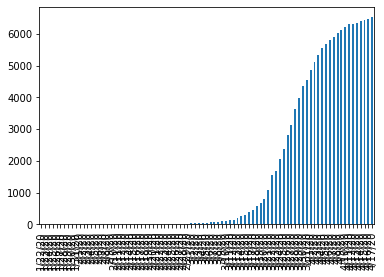

In [33]:
grouped1.plot(kind='bar', x='date')

## Comparing Countries

One of the classic displays in the news is the comparison between countries.  Select a number of countries and plot their data on the same graph to reproduce this visualisation. Suitable countries would be those who have significant outbreaks - China, USA, Italy, UK, Australia. 

In [38]:
grouped2=grouped.loc[['Australia', 'China', 'Italy', 'US', 'United Kingdom']].transpose()
grouped2

Country/Region,Australia,China,Italy,US,United Kingdom
1/22/20,0,548,0,1,0
1/23/20,0,643,0,1,0
1/24/20,0,920,0,2,0
1/25/20,0,1406,0,2,0
1/26/20,4,2075,0,5,0
...,...,...,...,...,...
4/13/20,6351,83213,159516,580619,89570
4/14/20,6415,83306,162488,607670,94845
4/15/20,6440,83356,165155,636350,99483
4/16/20,6462,83403,168941,667801,104145


Country/Region,Australia,China,Italy,US,United Kingdom
3/10/20,107,80887,10149,959,384
3/11/20,128,80921,12462,1281,459
3/12/20,128,80932,12462,1663,459
3/13/20,200,80945,17660,2179,802
3/14/20,250,80977,21157,2727,1144
3/15/20,297,81003,24747,3499,1145
3/16/20,377,81033,27980,4632,1551
3/17/20,452,81058,31506,6421,1960
3/18/20,568,81102,35713,7783,2642
3/19/20,681,81156,41035,13747,2716


In [9]:
#import seaborn as sns
#sns.pairplot(ndf3,hue='Country/Region')

**Challenge** A very useful visualisation shows the data for different countries aligned from the time that they have 100 confirmed cases.  To create this figure, you need to take only the part of each time series after the value is greater than or equal to 100 and then plot this starting at 0 on the x-axis.  This is a bit more involved but will allow you to explore Pandas a bit more.

In [41]:
grouped2.loc[(grouped2['Australia']>=100)]

Country/Region,Australia,China,Italy,US,United Kingdom
3/10/20,107,80887,10149,959,384
3/11/20,128,80921,12462,1281,459
3/12/20,128,80932,12462,1663,459
3/13/20,200,80945,17660,2179,802
3/14/20,250,80977,21157,2727,1144
3/15/20,297,81003,24747,3499,1145
3/16/20,377,81033,27980,4632,1551
3/17/20,452,81058,31506,6421,1960
3/18/20,568,81102,35713,7783,2642
3/19/20,681,81156,41035,13747,2716


## Normalisation by Population

The raw data includes the overall count of cases in each country. Clearly small countries will have smaller overall values than large countries.  It would be interesting to see whether the number of cases in China and the US was more per-capita than those in other countries and find which country has the highest number as a proportion of the population. (A good way to measure this is the number of cases per million people in the population. If a country has 25 cases and a population of 2.5 million they would have 10 cases per million).

To answer these questions we need population data. I'll present two possible sources of data (there are more of course) [datahub.io](https://datahub.io/JohnSnowLabs/population-figures-by-country) has data per country up to 2016 in a handy CSV format. The [United Nations Population Dynamics page](https://population.un.org/wpp/Download/Standard/CSV/) has data that predicts populations up to 2100 in CSV format.  Use one of these data sets to compute the number of confirmed cases for each country per million population.   Create a new plot with this data. Create a plot to compare the most recent day's data - which country has the most cases per million right now? 

_Note, to use the population data you'll have to make sure that the country names match up in the different data sets. There's no magic way to do this, either you edit one of the datasets or write code to modify the data once you read it in.  The second of these is better because it makes it easy for someone else to repeat your analysis._

## A Predictive Model

It is well understood that the spread of the virus follows an exponential pattern. This is because each infected person infects more than one new person on average, leading to exponential growth.  This is why the key to stopping the growth of the pandemic is to reduce the number of people infected by stopping contact and isolating infected poeple. 

An exponential curve has the equation $y = e^{mx}$. It can be converted to a linear relationship by taking the logarithm of each side: $log(y) = mx$.  This means that we can fit a linear regression model to the data as long as we take the log of the number of cases. 

Select a country with a clear exponential curve (for example, the US) and build a linear regression model to predict the log of the number of case.  Test how well the model fits the data. 

Now, select the data from China. This should show some divergence from the model since they have managed to slow the growth of cases.  Can you show from the model that China's data does not show exponential growth?   If China had not acted to stop the virus, how many cases would there be now according to this simple model? 

Can you use this metric to identify countries where the virus is under control and those where it is not? 

## Your Portfolio

This notebook should become part of your portfolio. This means you should remove most of my instructions and replace them with your own discussion of what you are doing.  Try to make this your own document about this dataset. It will become part of your portfolio of projects to show to future employers - make it your own.